In [1073]:
import io
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import sentencepiece as spm
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

### Preprocess the Data

In [1074]:
def dataframe_sentence_generator(df):
    for sentence in df:
        yield sentence.lower()

# Replace 'your_file.csv' with the path to your CSV file
file_path = './TitlesAndScoreAll.csv'
df = pd.read_csv(file_path, sep=',')

# Split the data into training and test sets
train_texts, test_texts, train_score, test_score = train_test_split(
    df['title'], 
    df['score'], 
    test_size=0.2, 
    random_state=42
)

### Train a SentencePiece Model

In [1075]:
spm.SentencePieceTrainer.train(
    sentence_iterator=dataframe_sentence_generator(train_texts), 
    model_prefix='spm_Alex_week2', 
    vocab_size=15000,
)

sp = spm.SentencePieceProcessor()
sp.load('spm_Alex_week2.model')

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: spm_Alex_week2
  model_type: UNIGRAM
  vocab_size: 15000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy

True

### Generate  Tokens

In [1076]:
tokenized_titles = []
for title in train_texts:
    tokanized_title = sp.encode_as_pieces(title)
    tokenized_titles.append(tokanized_title)

### Use Word2Vec to Generate Embeddings

In [1077]:
vector_size = 150
w2v_model = Word2Vec(
    sentences=tokenized_titles, 
    vector_size=vector_size, 
    window=5, 
    min_count=1, 
    workers=4,
    sg=1,
)

In [1078]:
def title_to_embedding(sp, title, vector_size):
    tokens = sp.encode_as_pieces(title)

    embeddings = []
    for token in tokens:
        if (token in w2v_model.wv): 
            embeddings.append(w2v_model.wv[token])

    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

### Create a PyTorch Dataset

In [1079]:
training_embeddings = np.empty((len(train_texts), vector_size), dtype=np.float64)
testing_embeddings = np.empty((len(test_texts), vector_size), dtype=np.float64)

for idx, title in enumerate(train_texts):
    training_embeddings[idx] = title_to_embedding(sp, title, vector_size)

for idx, title in enumerate(test_texts):
    testing_embeddings[idx] = title_to_embedding(sp, title, vector_size)

print(training_embeddings.shape)
print(testing_embeddings.shape)

(132644, 150)
(33162, 150)


In [1080]:
training_input_tensor_embeddings = torch.from_numpy(training_embeddings).float()
testing_input_tensor_embeddings = torch.from_numpy(testing_embeddings).float()

training_target_tensor = torch.from_numpy(train_score.values).view(-1, 1).float()
testing_target_tensor = torch.from_numpy(test_score.values).view(-1, 1).float()

print(training_input_tensor_embeddings.shape)
print(training_input_tensor_embeddings.shape)

torch.Size([132644, 150])
torch.Size([132644, 150])


### Define and Train the Neural Network

In [1081]:
# Define the model
Model = nn.Sequential(
    nn.Linear(vector_size, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

# Set the criterion
criterion = nn.MSELoss()

# Choose the optimizer
optimizer = optim.Adam(Model.parameters(), lr=0.0225)
losses_graph = []

epochs = 800
for epoch in range(1, epochs + 1):
    # Zero the gradients
    Model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs = Model(training_input_tensor_embeddings)
    
    # Calculate loss
    loss = criterion(outputs, training_target_tensor)
    # Print loss every 100 epochs
    if epoch % 100 == 0:
        Model.eval()
        with torch.no_grad():
            test_outputs = Model(testing_input_tensor_embeddings)
            test_loss = criterion(test_outputs, testing_target_tensor)
        print(f'Epoch [{epoch}/{epochs}], \
            Loss: {loss.item()} \t \
            Test Loss: {test_loss.item()} \t \
            Test: {test_outputs[0][0].item()} \t \
            Truth: {testing_target_tensor[0][0].item()}'
        )
        losses_graph.append([epoch, loss.item(), test_loss.item()])

    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    

Epoch [100/800],             Loss: 262.3584899902344 	             Test Loss: 273.6790466308594 	             Test: 2.903362274169922 	             Truth: 1.0
Epoch [200/800],             Loss: 259.6536560058594 	             Test Loss: 271.72052001953125 	             Test: 3.4105958938598633 	             Truth: 1.0
Epoch [300/800],             Loss: 258.0821838378906 	             Test Loss: 271.3189392089844 	             Test: 3.2037317752838135 	             Truth: 1.0
Epoch [400/800],             Loss: 256.9189147949219 	             Test Loss: 271.3894348144531 	             Test: 3.1759493350982666 	             Truth: 1.0
Epoch [500/800],             Loss: 255.3555145263672 	             Test Loss: 271.7075500488281 	             Test: 3.4247164726257324 	             Truth: 1.0
Epoch [600/800],             Loss: 252.88319396972656 	             Test Loss: 272.1854553222656 	             Test: 3.6781437397003174 	             Truth: 1.0
Epoch [700/800],             Loss: 250.

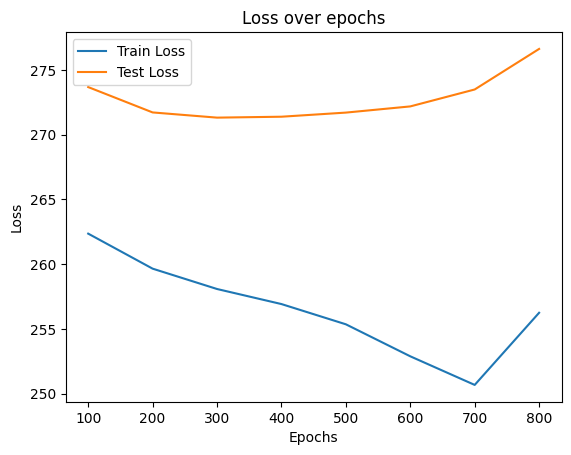

In [1082]:
losses_graph = np.array(losses_graph)
plt.plot(losses_graph[:, 0], losses_graph[:, 1], label='Train Loss')
plt.plot(losses_graph[:, 0], losses_graph[:, 2], label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1083]:
print(len(test_outputs))
print(testing_target_tensor[0])

for result in range(len(test_outputs)):
    print(f'Test: {test_outputs[result][0].item()} \t Truth: {testing_target_tensor[result][0].item()}')



33162
tensor([1.])
Test: 3.96681809425354 	 Truth: 1.0
Test: 6.558247089385986 	 Truth: 1.0
Test: 7.949836254119873 	 Truth: 82.0
Test: 5.221134662628174 	 Truth: 1.0
Test: 7.135514259338379 	 Truth: 1.0
Test: 7.784993648529053 	 Truth: 1.0
Test: 9.468174934387207 	 Truth: 1.0
Test: 10.084543228149414 	 Truth: 1.0
Test: 6.470669269561768 	 Truth: 1.0
Test: 11.78951644897461 	 Truth: 16.0
Test: 10.986860275268555 	 Truth: 1.0
Test: 5.08500862121582 	 Truth: 1.0
Test: 13.939379692077637 	 Truth: 21.0
Test: 10.014883995056152 	 Truth: 1.0
Test: 9.102334976196289 	 Truth: 1.0
Test: 10.078380584716797 	 Truth: 7.0
Test: 8.951990127563477 	 Truth: 21.0
Test: 6.141574859619141 	 Truth: 10.0
Test: 12.44636058807373 	 Truth: 2.0
Test: 2.437298536300659 	 Truth: 1.0
Test: 9.384218215942383 	 Truth: 1.0
Test: 9.182364463806152 	 Truth: 56.0
Test: 4.546606540679932 	 Truth: 3.0
Test: 7.7777791023254395 	 Truth: 1.0
Test: 11.778626441955566 	 Truth: 2.0
Test: 15.431089401245117 	 Truth: 1.0
Test: 7

Test: 9.339937210083008 	 Truth: 1.0
Test: 9.990856170654297 	 Truth: 14.0
Test: 7.990887641906738 	 Truth: 4.0
Test: 10.294717788696289 	 Truth: 109.0
Test: 8.100557327270508 	 Truth: 2.0
Test: 17.157529830932617 	 Truth: 2.0
Test: 6.632696151733398 	 Truth: 2.0
Test: 9.886197090148926 	 Truth: 1.0
Test: 11.424054145812988 	 Truth: 1.0
Test: 6.190977096557617 	 Truth: 1.0
Test: 5.633939266204834 	 Truth: 1.0
Test: 10.986608505249023 	 Truth: 2.0
Test: 14.076379776000977 	 Truth: 1.0
Test: 7.699264049530029 	 Truth: 60.0
Test: 10.524113655090332 	 Truth: 39.0
Test: 7.216266632080078 	 Truth: 1.0
Test: 8.053145408630371 	 Truth: 3.0
Test: 8.757463455200195 	 Truth: 1.0
Test: 7.355943202972412 	 Truth: 1.0
Test: 11.835691452026367 	 Truth: 1.0
Test: 4.273753643035889 	 Truth: 1.0
Test: 10.891222953796387 	 Truth: 19.0
Test: 6.4202728271484375 	 Truth: 1.0
Test: 5.3507304191589355 	 Truth: 1.0
Test: 10.490036964416504 	 Truth: 5.0
Test: 5.637274265289307 	 Truth: 3.0
Test: 12.296896934509